In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

# Notes on calculations

Calulation and definitions found here: 

https://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/ModelEvaluation.html#1_Introduction

## Although they say observed - predicted which is clearly wrong

In [2]:
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"

small_fire = fv.prep_fire_files(path)

fire = fv.prep_fire_files(path)


In [3]:

for i in range(1,9):
    small_fire[f"fwi_error_{i}"] =small_fire["FWI"] - small_fire[f"FWI_lead_{i}"]

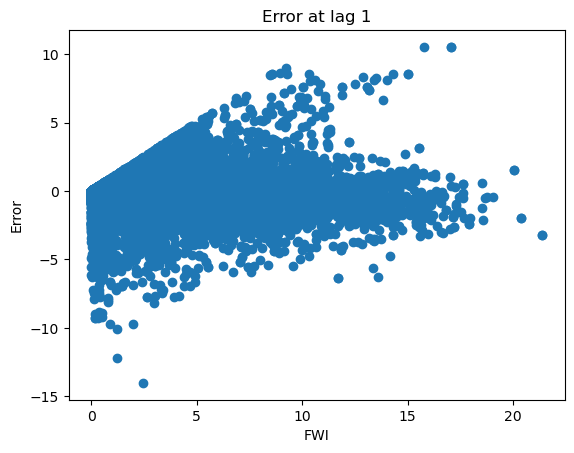

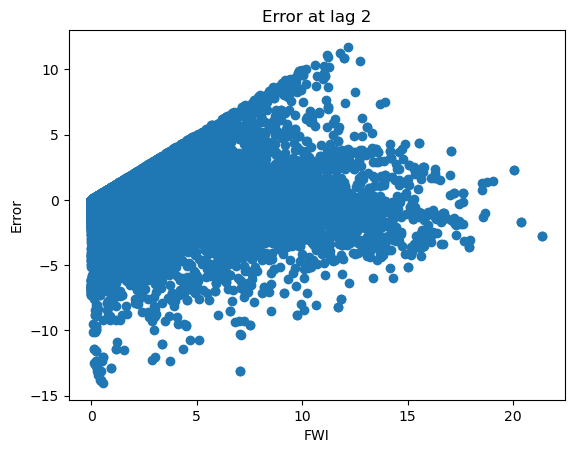

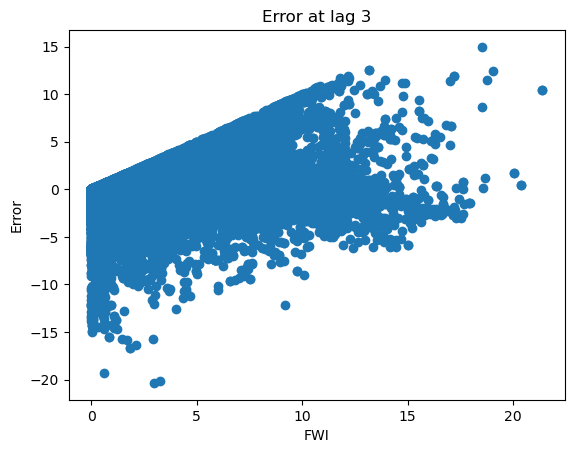

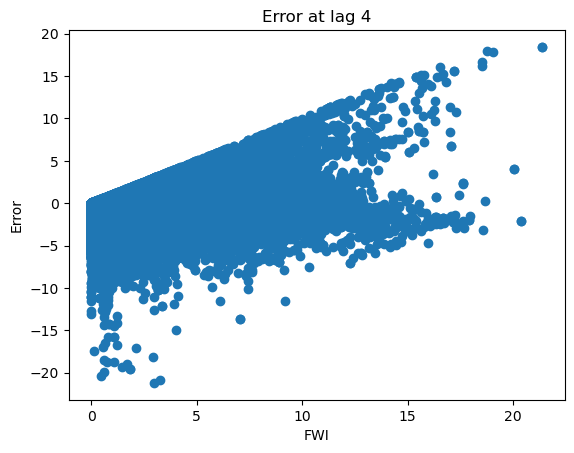

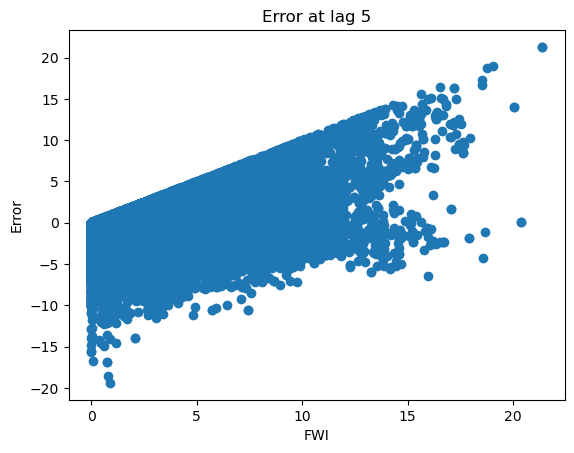

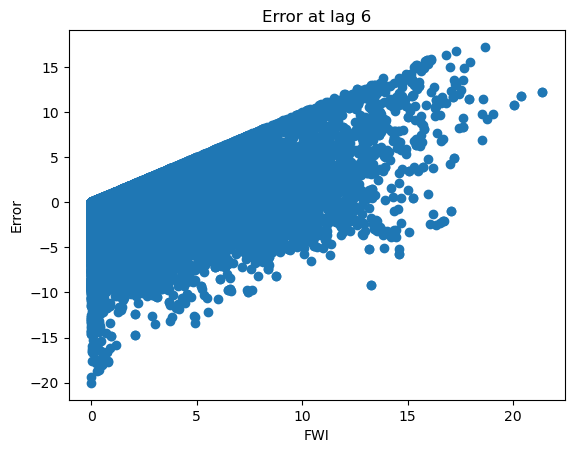

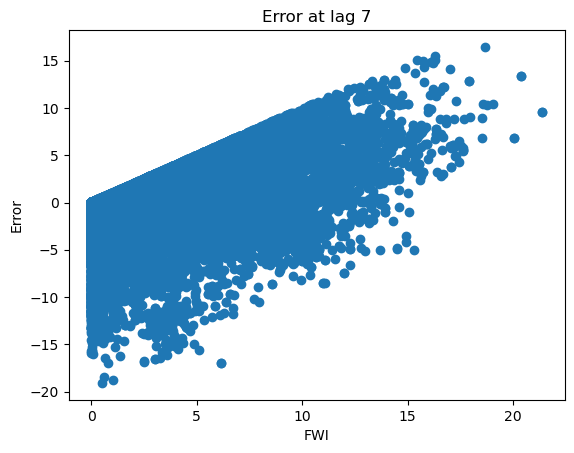

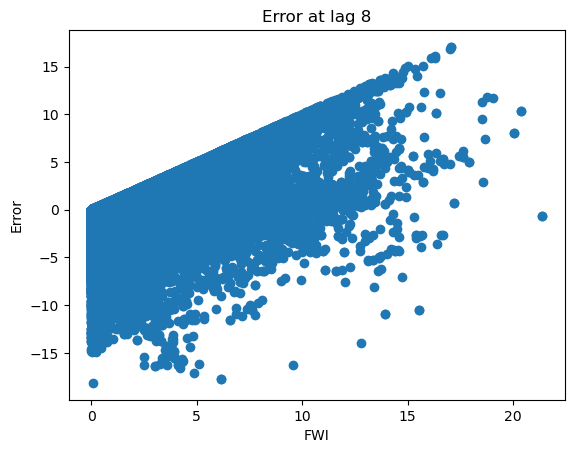

In [4]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"fwi_error_{i}"])
    plt.xlabel("FWI")
    plt.ylabel("Error")
    plt.title(f"Error at lag {i}")
    plt.show()

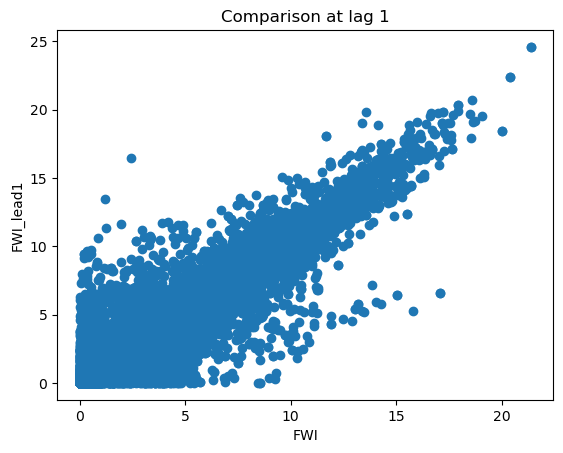

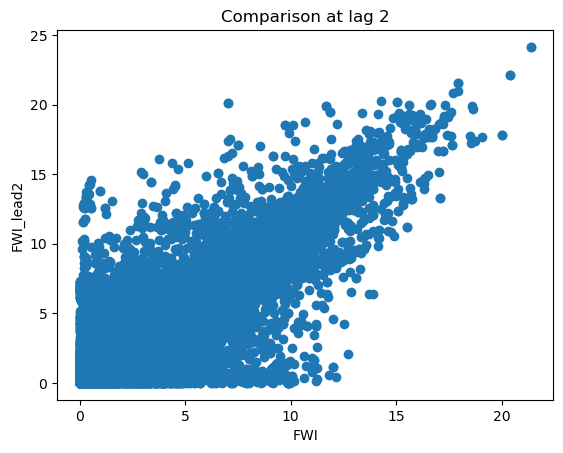

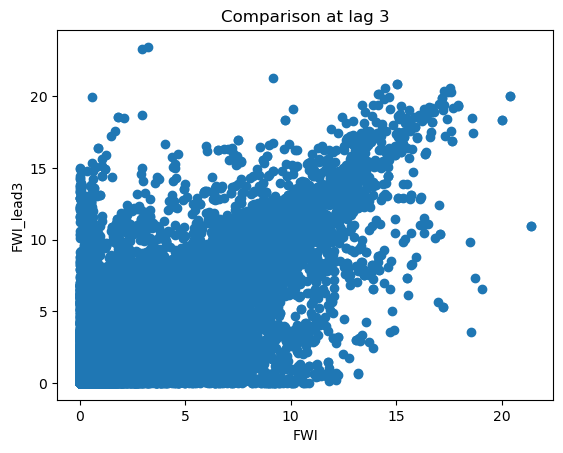

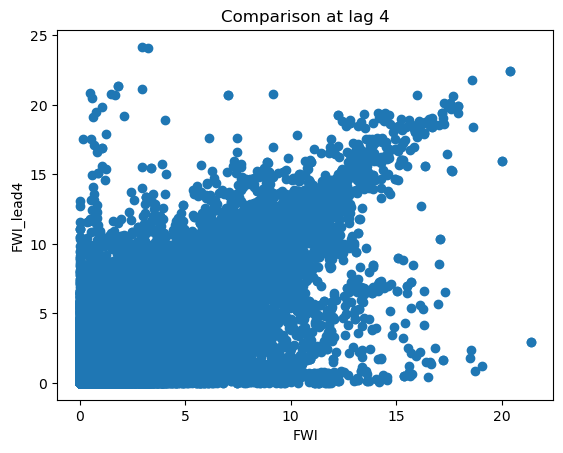

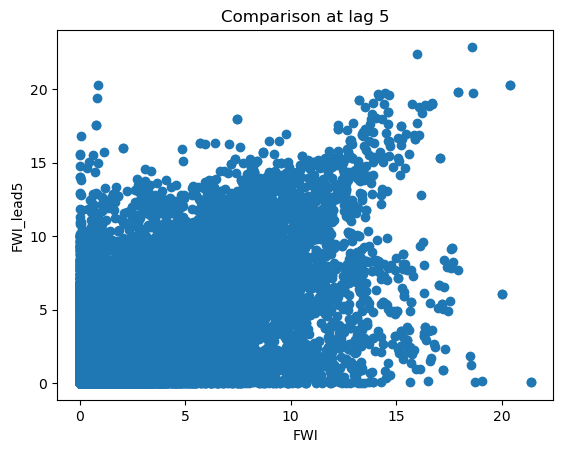

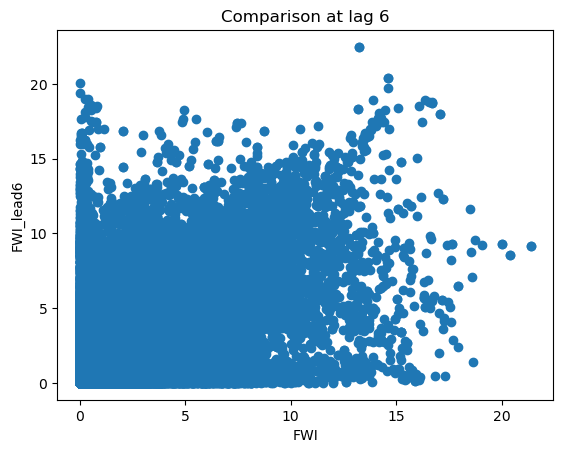

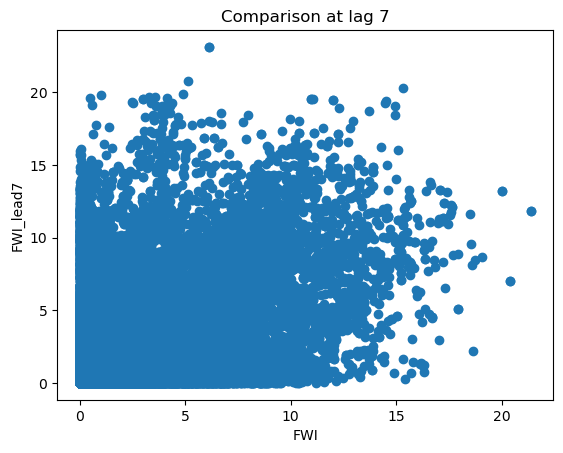

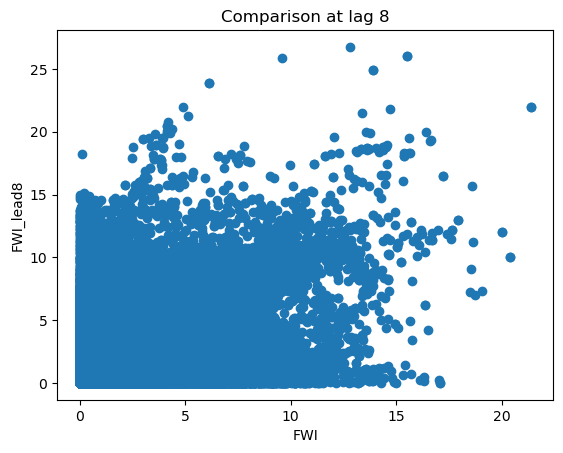

In [5]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [6]:
### Ok, see if you can get rid of duplicates for the purposes of plotting 

small_fire = small_fire[['GEOS-5.IMERGEARLY',
       'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_fire',
       'fwi_error_1', 'fwi_error_2', 'fwi_error_3', 'fwi_error_4',
       'fwi_error_5', 'fwi_error_6', 'fwi_error_7', 'fwi_error_8']]
small_fire = small_fire.drop_duplicates()
#small_fire.columns

In [7]:
len(small_fire)

41742

In [8]:
len(small_fire)

41742

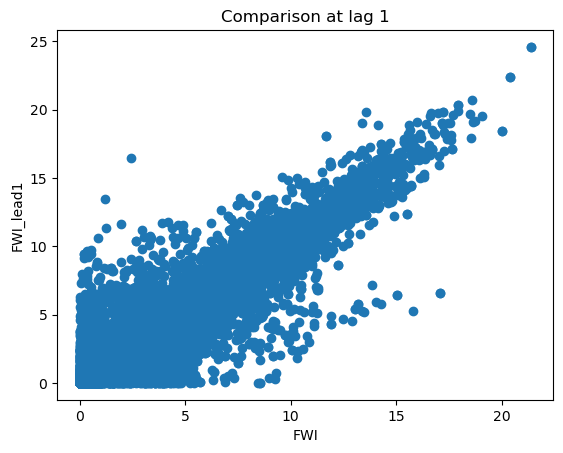

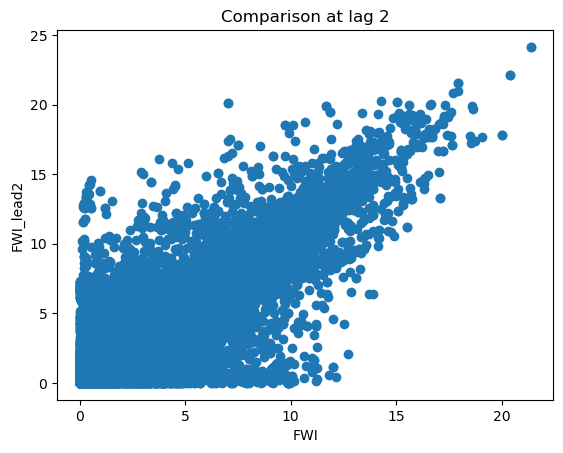

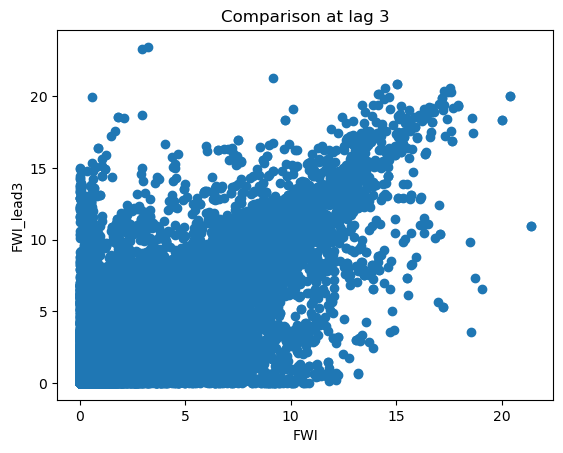

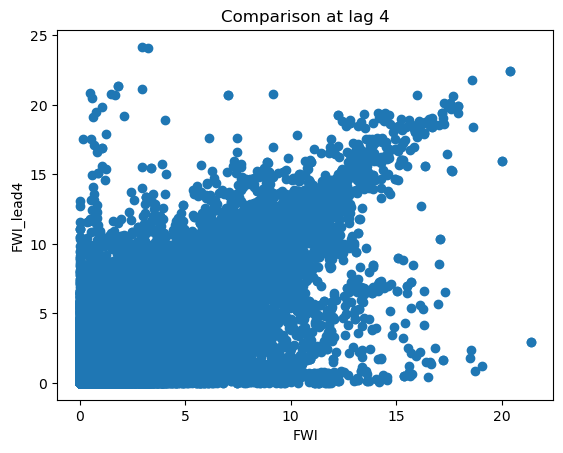

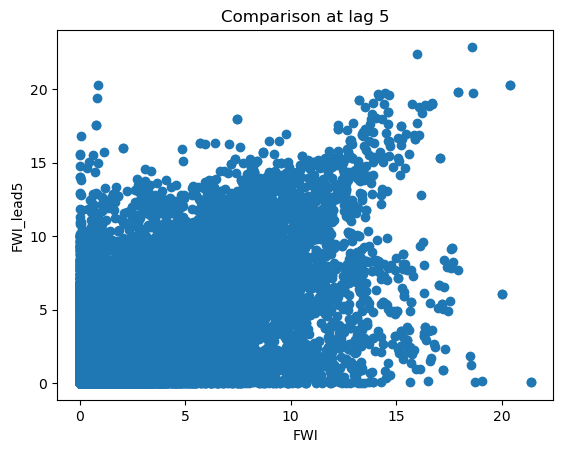

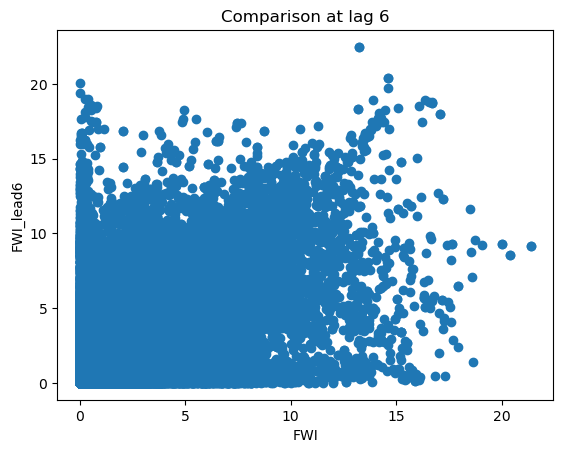

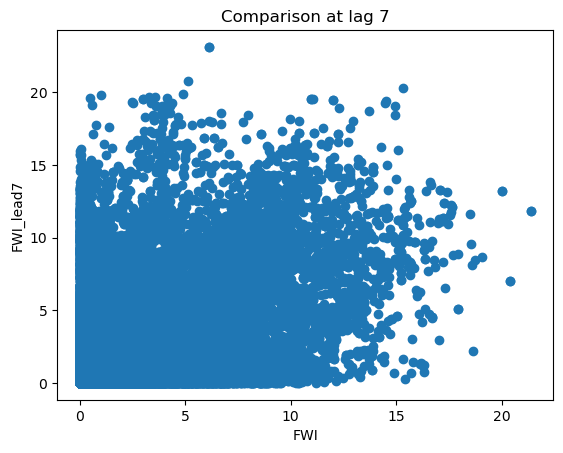

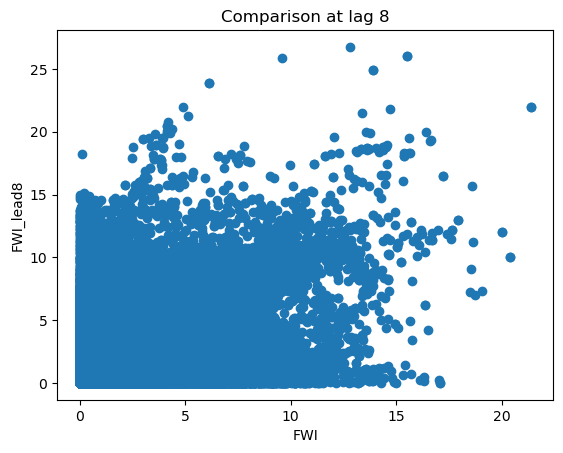

In [9]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [10]:
### BAD: BUT I JUST WANT TO LOOK TO SEE IF SUPER DIFFERENT

#small_fire["FWI"] = small_fire["GEOS-5.IMERGEARLY"]
#fire["FWI"] = fire["GEOS-5.IMERGEARLY"]

log_fire = small_fire
small_fire.columns
#log_fire = np.log(small_fire[['FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3','FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8']] + 1)

Index(['GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3',
       'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8',
       'pre_fire', 'fwi_error_1', 'fwi_error_2', 'fwi_error_3', 'fwi_error_4',
       'fwi_error_5', 'fwi_error_6', 'fwi_error_7', 'fwi_error_8'],
      dtype='object')

Summary Statistics for lag 1
R^2 from 1:1 (Variance explained): 0.888558175208287
Overall Bias/ mean predictor error: 0.11195471623000816


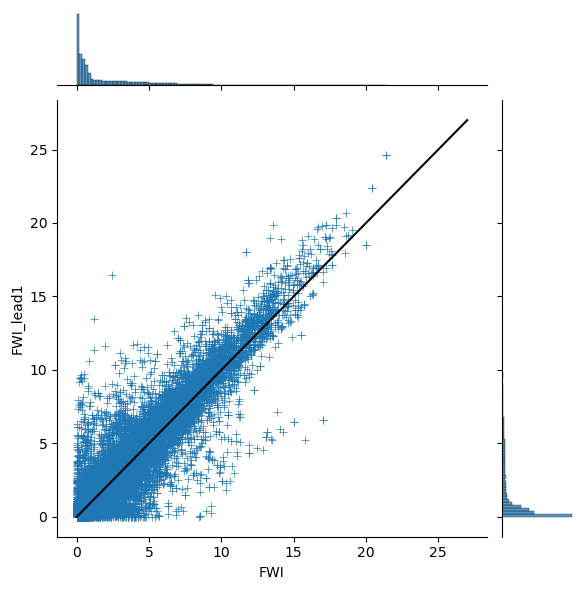

Summary Statistics for lag 2
R^2 from 1:1 (Variance explained): 0.7245238164286345
Overall Bias/ mean predictor error: 0.15634410232157153


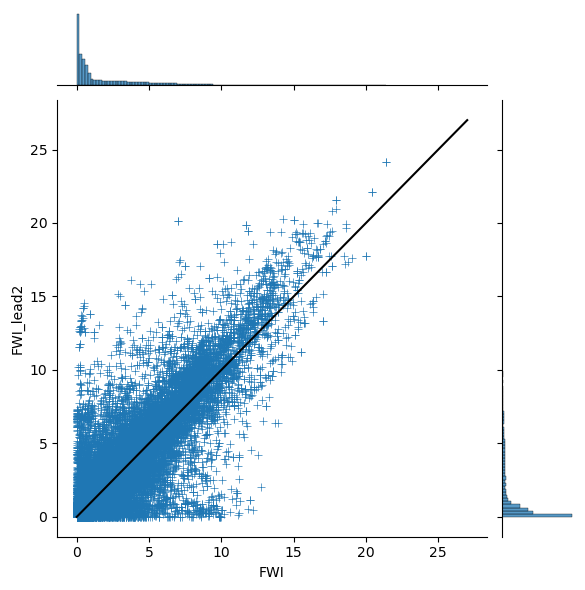

Summary Statistics for lag 3
R^2 from 1:1 (Variance explained): 0.5306676495893426
Overall Bias/ mean predictor error: 0.15593080519157507


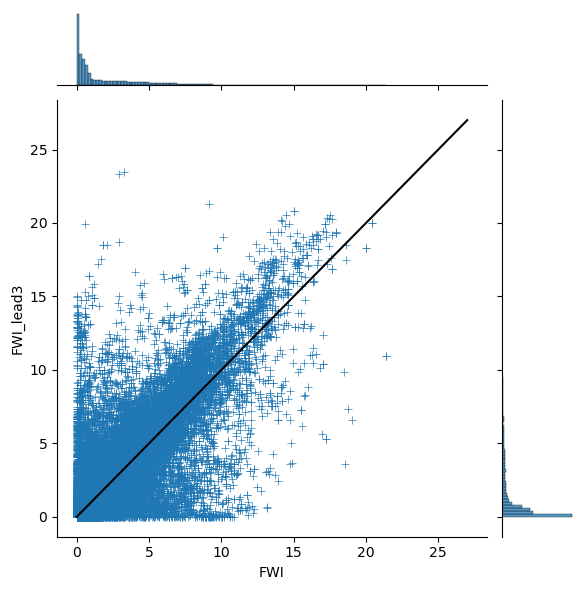

Summary Statistics for lag 4
R^2 from 1:1 (Variance explained): 0.3968029016908816
Overall Bias/ mean predictor error: 0.20864757437711373


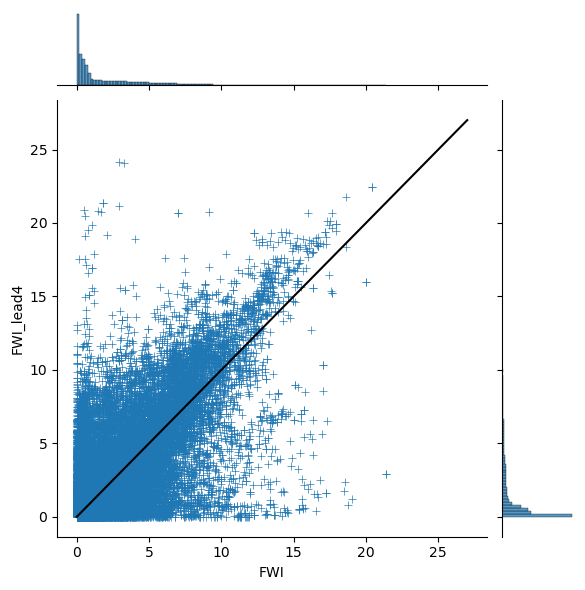

Summary Statistics for lag 5
R^2 from 1:1 (Variance explained): 0.2481453385903979
Overall Bias/ mean predictor error: 0.17720202620085568


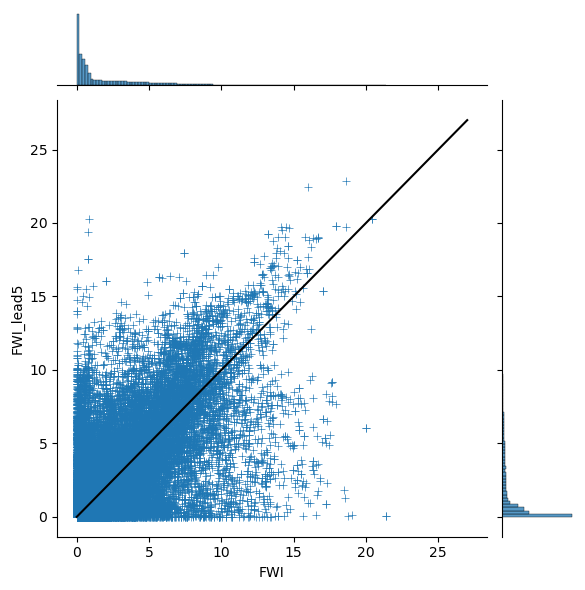

Summary Statistics for lag 6
R^2 from 1:1 (Variance explained): 0.08217953326647198
Overall Bias/ mean predictor error: 0.16298650643443152


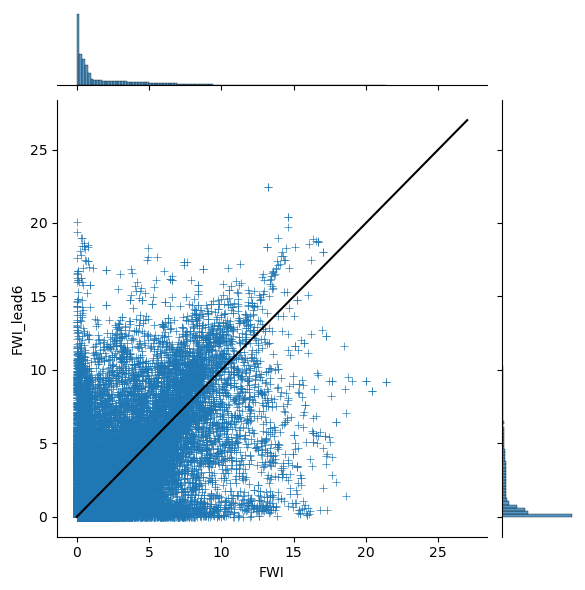

Summary Statistics for lag 7
R^2 from 1:1 (Variance explained): -0.09740021793467446
Overall Bias/ mean predictor error: 0.1642444302061299


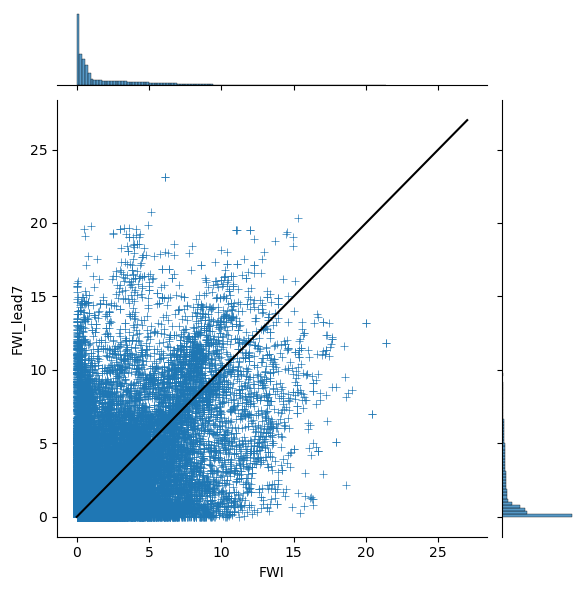

Summary Statistics for lag 8
R^2 from 1:1 (Variance explained): -0.17992744580642284
Overall Bias/ mean predictor error: 0.1250226005121313


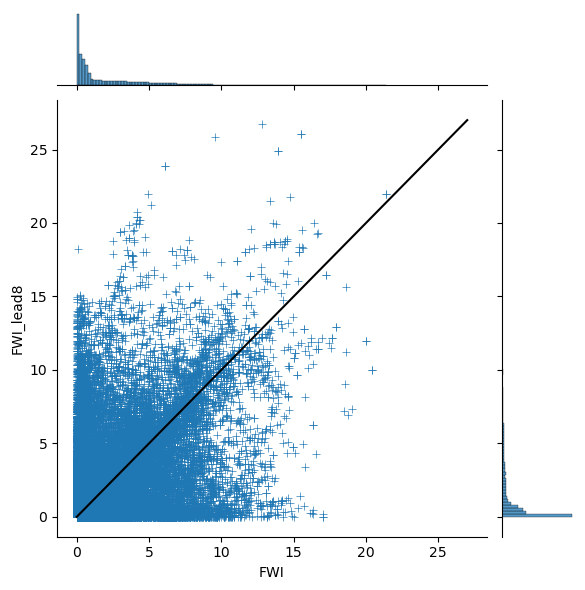

In [45]:
import seaborn as sns 

r_sq_list = []
bias_list = []
rmse_list = []
iterator = []
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=log_fire, x="FWI", y=f"FWI_lead_{i}", marker="+") 
    plt.plot(range(0,28), range(0,28), color = "black")
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    
    ## Stats
    r_sq = 1 - (np.sum((log_fire.FWI - log_fire[f"FWI_lead_{i}"])**(2)) / np.sum((log_fire.FWI - log_fire.FWI.mean())**(2)))
    bias = np.sum( log_fire[f"FWI_lead_{i}"] - log_fire.FWI )/len(log_fire[f"FWI_lead_{i}"])
    rmse = ((np.sum((log_fire[f"FWI_lead_{i}"] - log_fire.FWI)**2))/len(log_fire[f"FWI_lead_{i}"]))**(1/2)
    #plt.title(f"Comparison at lag {i}")
    print(f"Summary Statistics for lag {i}")
    print("R^2 from 1:1 (Variance explained): " + str(r_sq) )
    print("Overall Bias/ mean predictor error: " + str(bias) )
    rmse_list.append(rmse)
    r_sq_list.append(r_sq)
    bias_list.append(bias)
    iterator.append(i)
    
    plt.show()

decay_stats = pd.DataFrame({"lag_day": iterator, "RMSE": rmse_list, "r_sq": r_sq_list, "bias":bias_list, })
# here "*" is used as a marker for scatterplot 

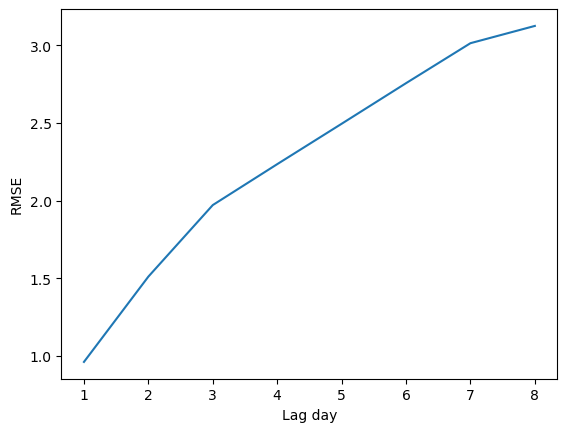

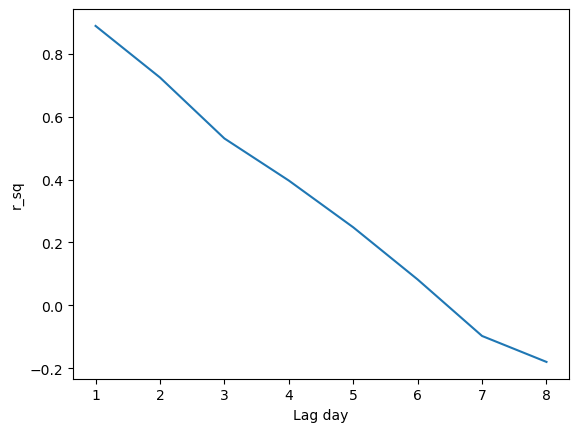

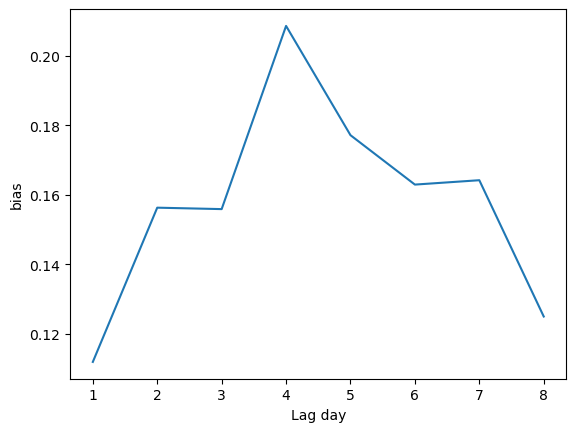

In [48]:
stats = ["RMSE", "r_sq", "bias"]

for s in stats:
    plt.plot(decay_stats.lag_day, decay_stats[s])
    plt.xlabel("Lag day")
    plt.ylabel(s)
    plt.show()

In [12]:
bins = 10
slices = np.linspace(0, 100, bins+1, True)
slices

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

/tmp/ipykernel_4617/3252151122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_fire["FWI_round"][small_fire["FWI_round"] >= 17] = 17


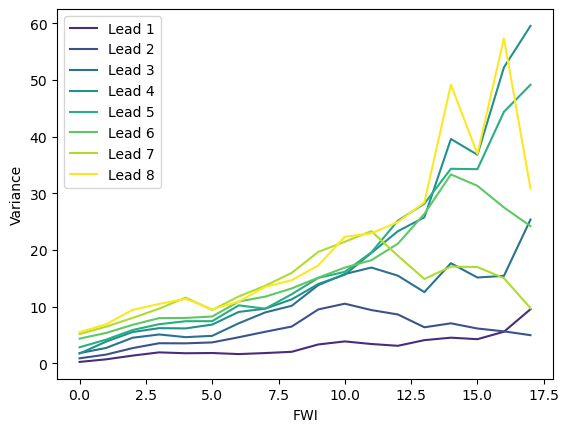

In [17]:
## Calculate the varience at different FWI and lag values
small_fire["FWI_round"] = np.round(small_fire.FWI)
small_fire["FWI_round"][small_fire["FWI_round"] >= 17] = 17



def calc_bias(df, i):
    tmp = np.sum( df[f"FWI_lead_{i}"] - df["FWI"])/len(df[f"FWI_lead_{i}"])
    #print(len(df["FWI"]))
    return(tmp)

def RMSE(df, i):
    tmp = (np.sum((df[f"FWI_lead_{i}"] - df["FWI"])**(2))/len(df[f"FWI_lead_{i}"]))**(1/2)
    return(tmp)

#cmap = plt.get_cmap('viridis')
colors = plt.cm.viridis(np.linspace(0,1,9))

for i in range(1,9):
    test_var = small_fire.groupby("FWI_round")[f"FWI_lead_{i}"].var().reset_index()
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Variance")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()
    

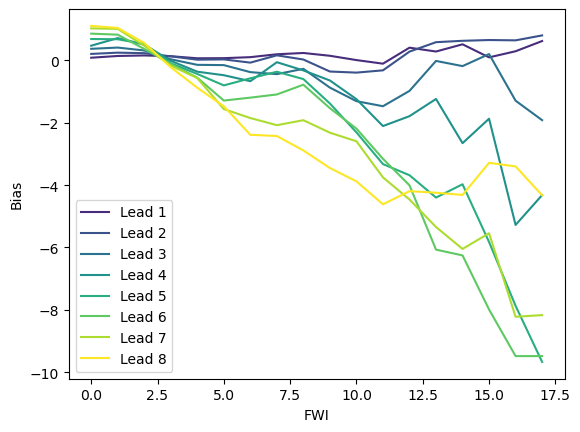

In [18]:
for i in range(1,9):
    test_var = small_fire.groupby("FWI_round").apply(calc_bias, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"FWI_lead_{i}"})
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Bias")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

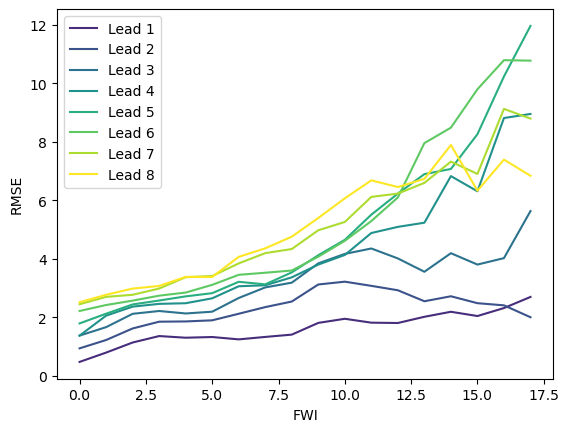

In [20]:
for i in range(1,9):
    test_var = small_fire.groupby("FWI_round").apply(RMSE, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"FWI_lead_{i}"})
    #print(test_var)
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"RMSE")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

# Now try to see if I can capture "changes in the timeseries". 

The goal is to find a mechnism that rewards capturing inflection points. This could have a couple of meanings: 

"How many days in advance did we get the inflection point correct" <-- possbily useful interpretation


"Were we able to spot the inflection point when the 


"Were we better at predicting the weather when it was getting hotter(more FWI) ore colder (less FWI)?"
- Calculate deltas, color-code scatterplots by deltas? Calculate r^2 on binned-deltas like I'm doing with Bias/ variance? 
- plot delta vs delta like above
- somehow plot delta skill one axis, FWI on other
    - T_4 - T_3, indexed by T_4  compared to forecasted T_4 - T_3 @ T_4 (actual) (Aka "The difference between 
        - FWI @T_3 = 10 FWI @T_4 = 16, forecastsed @T_3 was 6 and @ T_4 was 9. "Real delta" was 6, "Forecasted delta" was 3. @ FWI of 16, Delta forecast was off by 3



In [21]:
small_fire

,GEOS-5.IMERGEARLY,FWI,FWI_lead_1,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,FWI_lead_7,FWI_lead_8,pre_fire,fwi_error_1,fwi_error_2,fwi_error_3,fwi_error_4,fwi_error_5,fwi_error_6,fwi_error_7,fwi_error_8,FWI_round
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,6.663517e+00,2.683968,3.278344,0.955101,0.420523,0.709179,0.674337,0.606341,2.067747e+00,0.000338,False,-0.594376,1.728868,2.263445,1.974789,2.009632,2.077627,0.616221,2.683630,3.0
110,1.437628e+01,11.418555,12.995580,14.016458,14.630502,13.414138,9.812151,8.670969,8.733346e+00,1.585756,False,-1.577025,-2.597903,-3.211947,-1.995584,1.606404,2.747586,2.685209,9.832799,11.0
113,1.141874e+01,8.719515,9.762177,10.520937,9.820648,9.241083,5.251108,5.408271,2.862681e+00,6.908187,False,-1.042662,-1.801422,-1.101134,-0.521569,3.468406,3.311243,5.856833,1.811328,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105894,1.960134e-01,0.183429,0.161515,NaN,0.238760,0.512801,NaN,NaN,NaN,NaN,False,0.021915,NaN,-0.055330,-0.329371,NaN,NaN,NaN,NaN,0.0
105895,1.812998e-07,0.000028,0.008582,NaN,NaN,0.000007,0.000749,NaN,NaN,NaN,False,-0.008554,NaN,NaN,0.000021,-0.000721,NaN,NaN,NaN,0.0
105896,2.408940e-01,0.003627,0.000077,0.000017,NaN,0.154147,0.000299,0.003384,NaN,0.009938,False,0.003550,0.003611,NaN,-0.150519,0.003328,0.000243,NaN,-0.006311,0.0
105897,NaN,NaN,NaN,NaN,NaN,NaN,0.096319,0.000073,3.579051e-07,0.000288,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
fire_delta = fire.sort_values(by = ["fireID", "t"])

In [23]:
def group_level_diff(df, var):
    df["diff_" + var] = df[var].diff()
    return(df)

In [24]:
fire_delta = fire_delta[["fireID", "t", 'GEOS-5.IMERGEARLY',
       'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8']]

#fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, "FWI").reset_index()

In [25]:
# smol = fire_delta[fire_delta.fireID == "10013"]

# smol["diff_FWI"] = smol.FWI.diff()
# #smol[~smol.FWI.isna()]
# smol[smol.t >= "2023-05-03"]

In [26]:
fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, "FWI").reset_index( drop = True)
for i in range(1,9):
    fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, f"FWI_lead_{i}").reset_index( drop = True)
fire_delta

,fireID,t,GEOS-5.IMERGEARLY,FWI,FWI_lead_1,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,...,FWI_lead_8,diff_FWI,diff_FWI_lead_1,diff_FWI_lead_2,diff_FWI_lead_3,diff_FWI_lead_4,diff_FWI_lead_5,diff_FWI_lead_6,diff_FWI_lead_7,diff_FWI_lead_8
0,10013,2023-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10013,2023-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10013,2023-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10013,2023-01-04 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10013,2023-01-05 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105966,9844,2024-01-04 12:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105967,9844,2024-01-05 12:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105968,9844,2024-01-06 12:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105969,9844,2024-01-07 12:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
fire_delta.columns

Index(['fireID', 't', 'GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1', 'FWI_lead_2',
       'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7',
       'FWI_lead_8', 'diff_FWI', 'diff_FWI_lead_1', 'diff_FWI_lead_2',
       'diff_FWI_lead_3', 'diff_FWI_lead_4', 'diff_FWI_lead_5',
       'diff_FWI_lead_6', 'diff_FWI_lead_7', 'diff_FWI_lead_8'],
      dtype='object')

Summary Statistics for lag 1
R^2 from 1:1 (Variance explained): 0.6863584645820787
Overall Bias/ mean predictor error: 0.006456056549231609


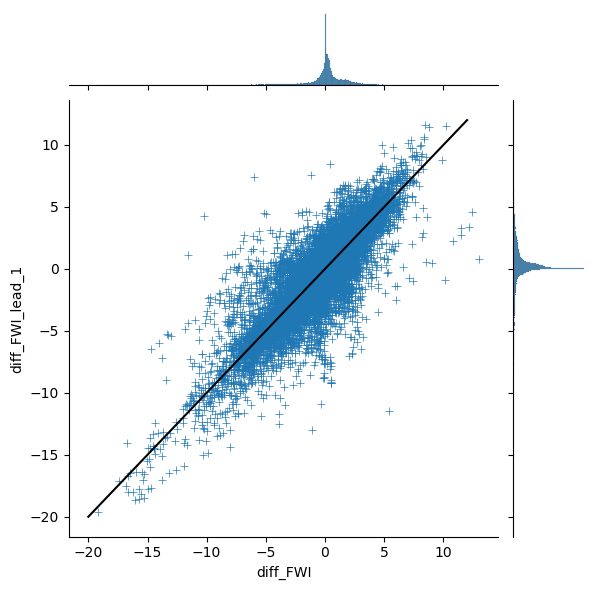

Summary Statistics for lag 2
R^2 from 1:1 (Variance explained): 0.3255001539305107
Overall Bias/ mean predictor error: -0.001479432753670605


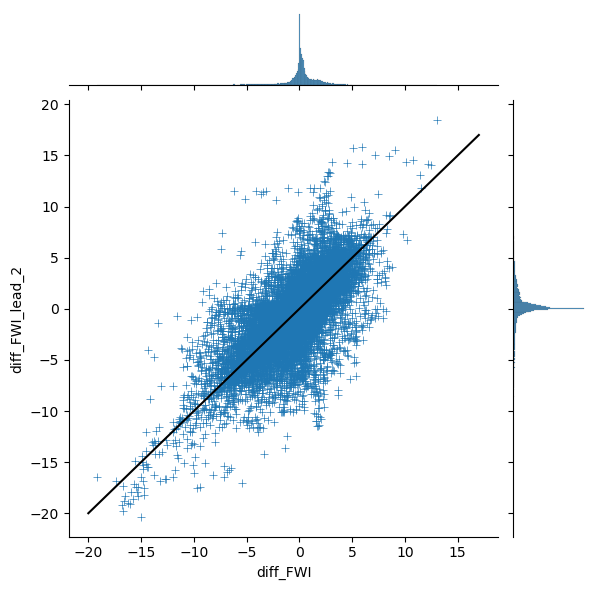

Summary Statistics for lag 3
R^2 from 1:1 (Variance explained): -0.09019807759542253
Overall Bias/ mean predictor error: 0.004096528722851701


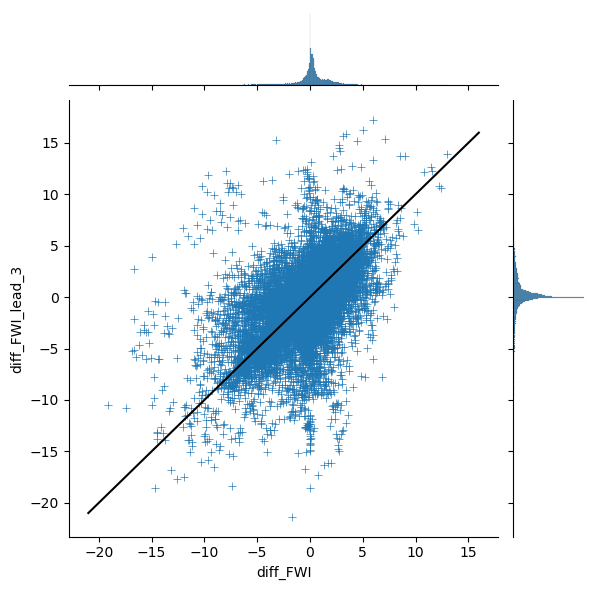

Summary Statistics for lag 4
R^2 from 1:1 (Variance explained): -0.49174959855970535
Overall Bias/ mean predictor error: -0.006932760643103285


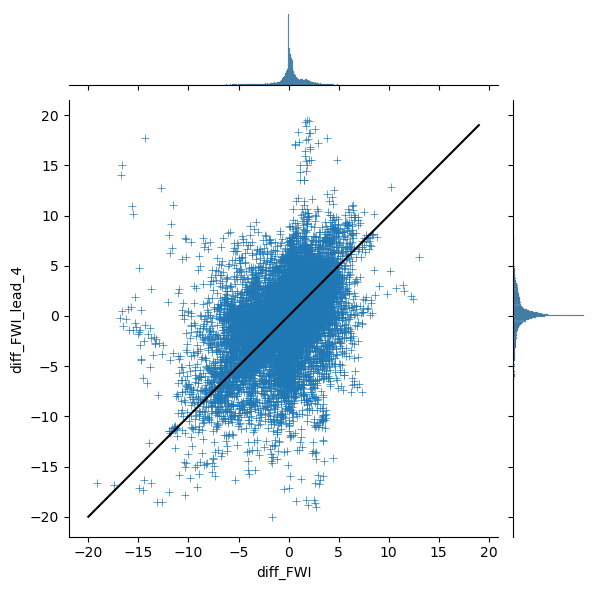

Summary Statistics for lag 5
R^2 from 1:1 (Variance explained): -0.862358961186708
Overall Bias/ mean predictor error: 0.003337397599518354


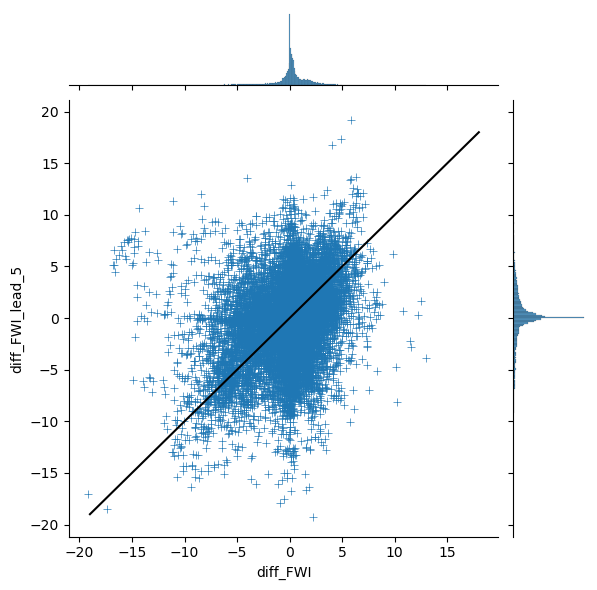

Summary Statistics for lag 6
R^2 from 1:1 (Variance explained): -1.2225950502739007
Overall Bias/ mean predictor error: 0.04076915410486928


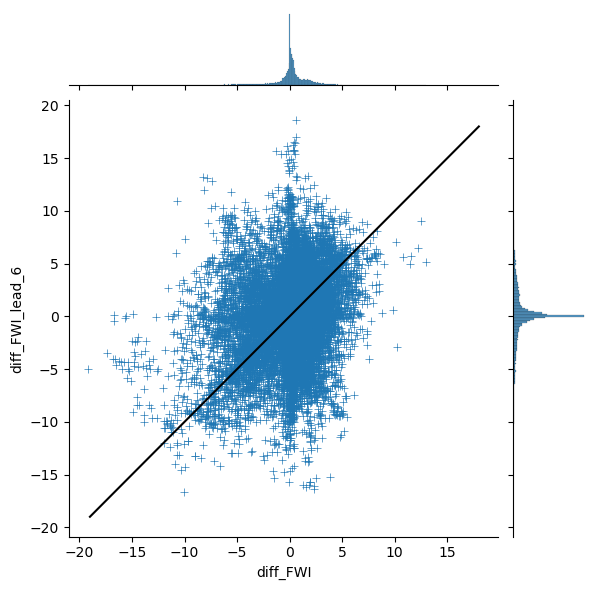

Summary Statistics for lag 7
R^2 from 1:1 (Variance explained): -1.8038176099238994
Overall Bias/ mean predictor error: -0.03034938972217795


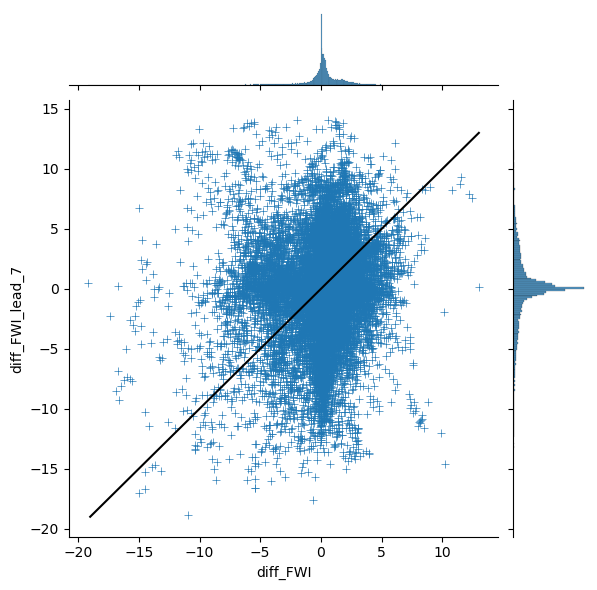

Summary Statistics for lag 8
R^2 from 1:1 (Variance explained): -1.5306749391077359
Overall Bias/ mean predictor error: -0.04068077399609315


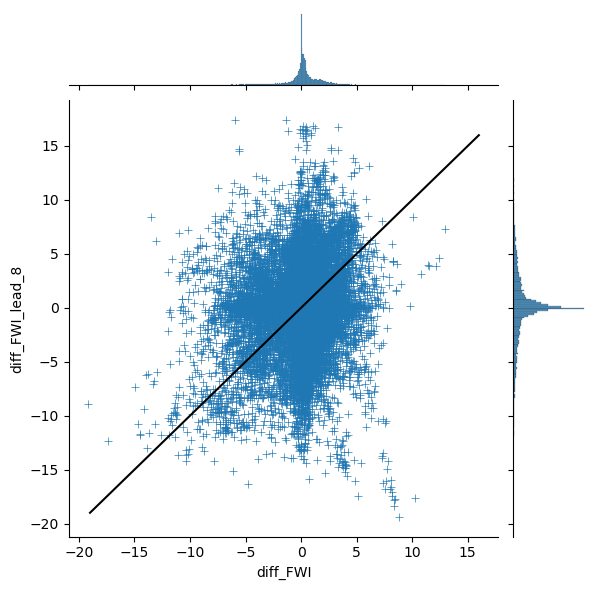

In [34]:
### Drop duplicates to account for oversampling

fire_delta = fire_delta[['FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'diff_FWI', 'diff_FWI_lead_1', 'diff_FWI_lead_2',
       'diff_FWI_lead_3', 'diff_FWI_lead_4', 'diff_FWI_lead_5',
       'diff_FWI_lead_6', 'diff_FWI_lead_7', 'diff_FWI_lead_8']]
fire_delta = fire_delta.drop_duplicates()


### Summary stats for CHANGE in FWI predictions

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=fire_delta, x="diff_FWI", y=f"diff_FWI_lead_{i}", marker="+") 
    max_of_max = round(max(fire_delta[f"diff_FWI_lead_{i}"].max(), fire_delta.diff_FWI.max()))
    min_of_min = round(min(fire_delta[f"diff_FWI_lead_{i}"].min(), fire_delta.diff_FWI.min()))
    
    
    plt.plot(range(min_of_min, max_of_max), range(min_of_min, max_of_max), color = "black")
    plt.xlabel("diff_FWI")
    plt.ylabel(f"diff_FWI_lead_{i}")
    
    ## Stats
    r_sq = 1 - (np.sum((fire_delta.diff_FWI - fire_delta[f"diff_FWI_lead_{i}"])**(2)) / np.sum((fire_delta.diff_FWI - fire_delta.diff_FWI.mean())**(2)))
    bias = np.sum(fire_delta[f"diff_FWI_lead_{i}"] - fire_delta.diff_FWI )/len(fire_delta.diff_FWI)
    #plt.title(f"Comparison at lag {i}")
    print(f"Summary Statistics for lag {i}")
    print("R^2 from 1:1 (Variance explained): " + str(r_sq) )
    print("Overall Bias/ mean predictor error: " + str(bias) )
    plt.show()

In [29]:
#type(fire_delta.FWI)

#tmp = pd.cut(fire_delta.FWI.values, bins= 5, include_lowest = True)




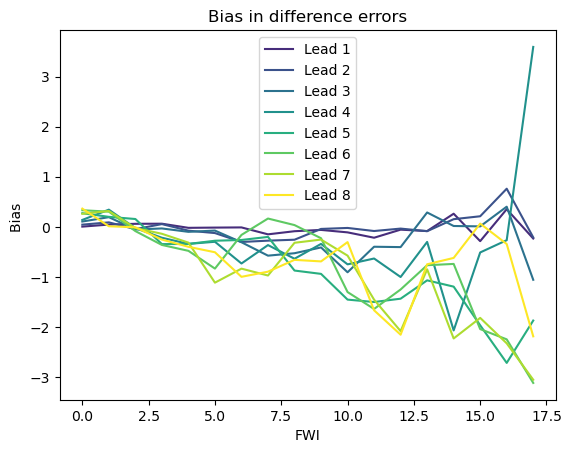

In [32]:
### See if there is systematic bias in the differenced stuff

## Calculate the varience at different FWI and lag values
fire_delta["FWI_round"] = np.round(fire_delta.FWI)
fire_delta["FWI_round"][fire_delta["FWI_round"] > 17] = 17
#fire_delta["FWI_binned"] = pd.cut(fire_delta.FWI.values, bins= 5, include_lowest = True) ## Becomes catagorical data an messes up plotting below


# def calc_bias(df, i):
#     tmp = np.sum(df[f"FWI_lead_{i}"] - df["FWI"])/len(df[f"FWI_lead_{i}"])
#     return(tmp)

def calc_bias_diff(df, i):
    tmp = np.sum( df[f"diff_FWI_lead_{i}"] - df["diff_FWI"])/len(df[f"diff_FWI_lead_{i}"])
    #print(len(df[f"diff_FWI_lead_{i}"]))
    #print(df["FWI_round"].unique())
    return(tmp)

def RMSE_diff(df, i):
    tmp = (np.sum((df[f"diff_FWI_lead_{i}"] - df["diff_FWI"])**(2))/len(df[f"diff_FWI_lead_{i}"]))**(1/2)
    return(tmp)

    

#cmap = plt.get_cmap('viridis')
colors = plt.cm.viridis(np.linspace(0,1,9))

bin_var = "FWI_round" # "FWI_round"
for i in range(1,9):
    test_var = fire_delta.groupby(bin_var).apply(calc_bias_diff, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"diff_FWI_lead_{i}"})
    plt.plot(test_var[bin_var], test_var[f"diff_FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Bias ")
    plt.title("Bias in difference errors")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

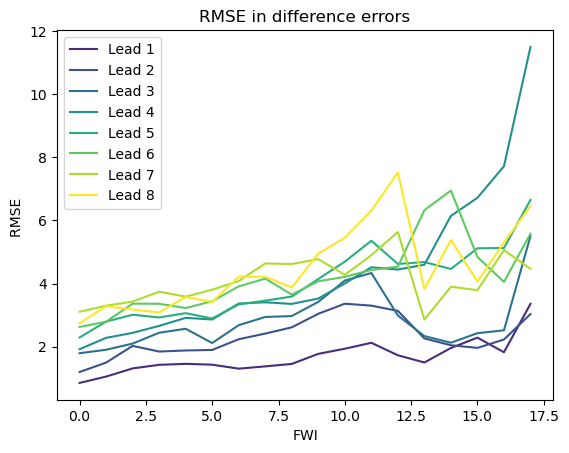

In [33]:
bin_var = "FWI_round" # "FWI_round"
for i in range(1,9):
    test_var = fire_delta.groupby(bin_var).apply( RMSE_diff, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"diff_FWI_lead_{i}"})
    plt.plot(test_var[bin_var], test_var[f"diff_FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"RMSE ")
    plt.title("RMSE in difference errors")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()    

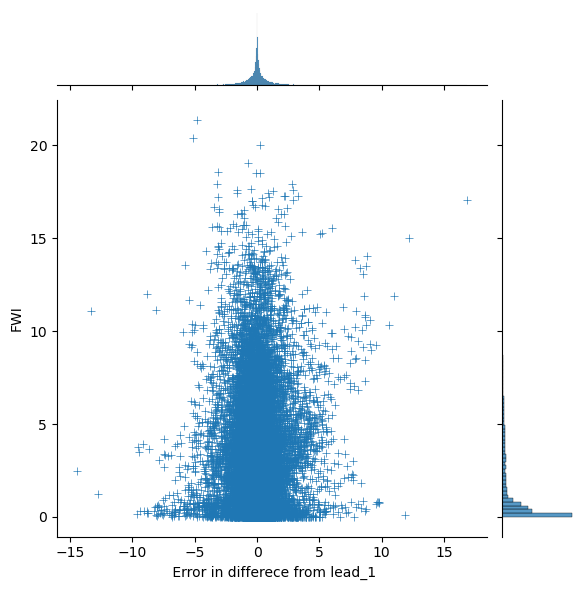

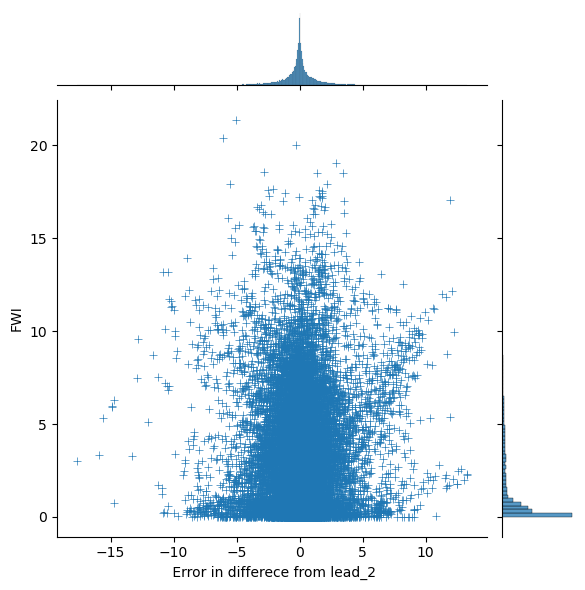

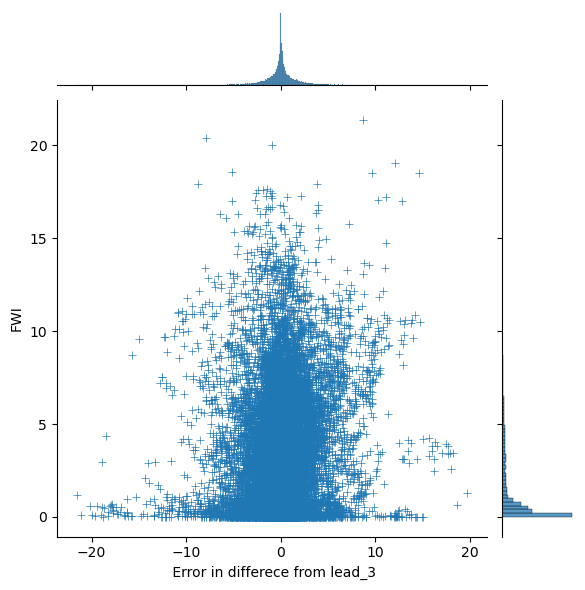

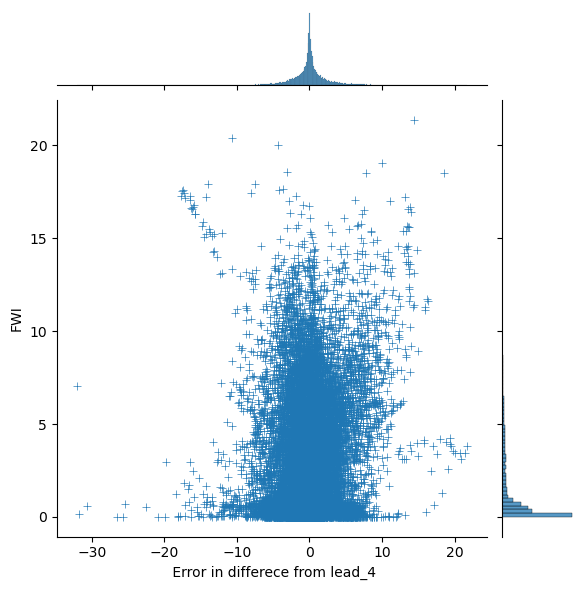

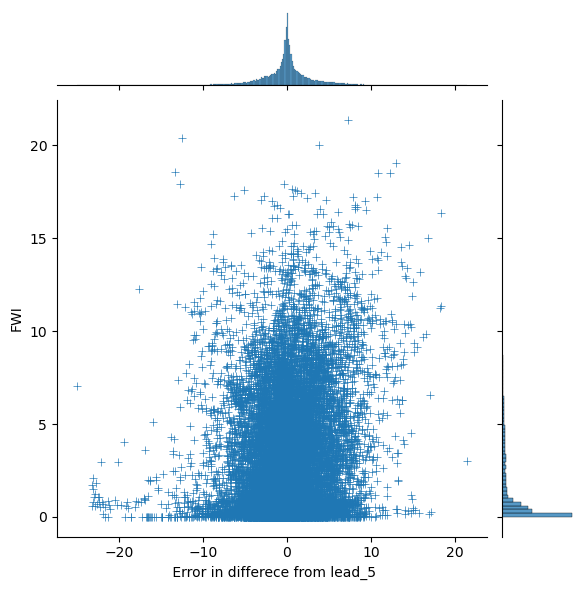

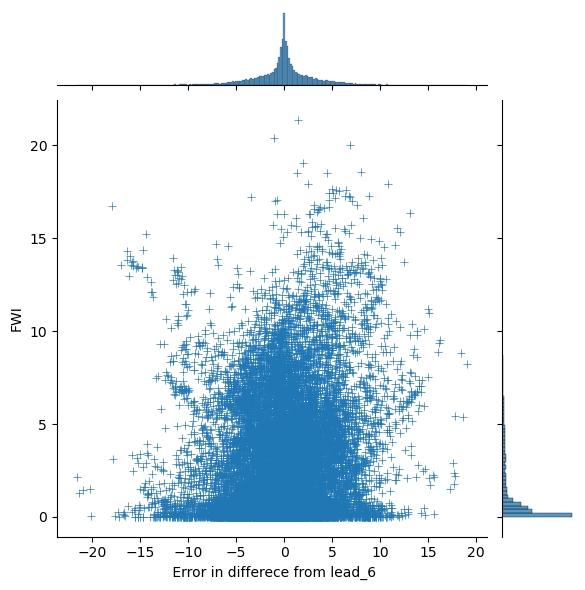

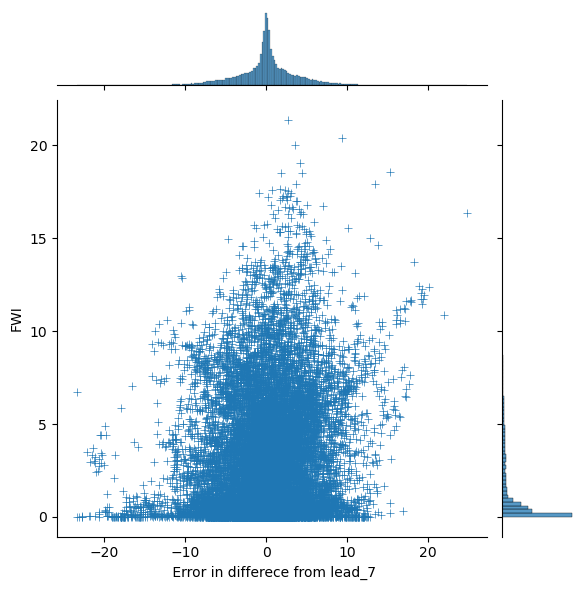

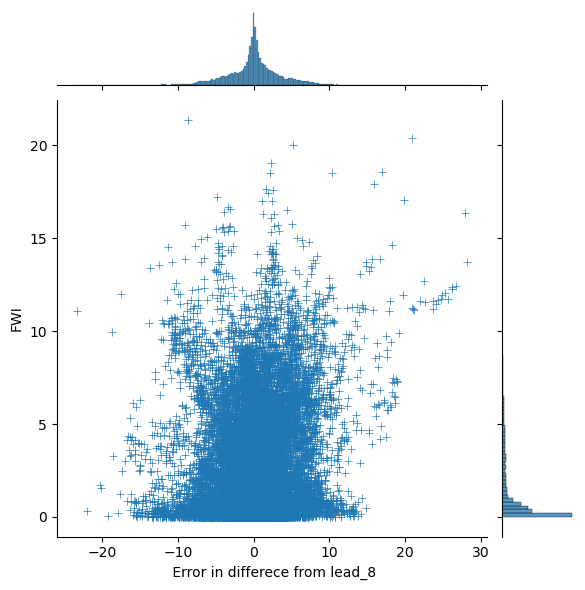

In [31]:
## Plot error by FWI

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=fire_delta, y="FWI", x=fire_delta.diff_FWI - fire_delta[f"diff_FWI_lead_{i}"], marker="+") 
    #max_of_max = round(max(fire_delta[f"diff_FWI_lead_{i}"].max(), fire_delta.diff_FWI.max()))
    #min_of_min = round(min(fire_delta[f"diff_FWI_lead_{i}"].min(), fire_delta.diff_FWI.min()))
    
    
    #plt.plot(range(min_of_min, max_of_max), range(min_of_min, max_of_max), color = "black")
    plt.ylabel("FWI")
    plt.xlabel(f" Error in differece from lead_{i}")
    
    ## Stats
    plt.show()